# Algorithm step-by-step visual explanation

All python code could be safely skipped. I used this for visualisations only.

In [1]:
import matplotlib.pyplot as plt
import random

from daugman_visual_explanation import DaugmanVisualExplanation
from daugman import find_iris

In [2]:
# fixed size for matplotlib output
plt.rcParams['figure.figsize'] = [5, 5]
# for replicability
random.seed(2020)

dve = DaugmanVisualExplanation('eye.jpg')

### The Daugman's part

Daugman algorythm measures difference in average pixel intensities on grayscale image for a bunch of circles with the same center and different radius.

The idea is to find the biggest drop in intensivety values between two neighbor circles. 
It should imply the transaction between iris and it's surroundings.

E.g., on the below image, yellow, green and red circles have the same pixel intensetives because all pixel underneath are black. Thus deltas (difference) between all those intensities are 0 (yellow-green, green-red).
But pixels under the blue circle are all white, so red-blue difference is the highest, which means that red circle is the best guess for iris border.

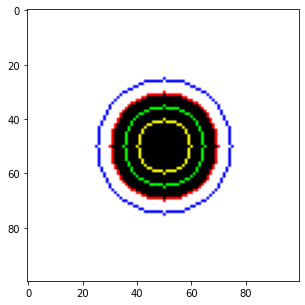

In [6]:
dve.plot_pixel_intensity_delta_pic()

Ideally, for best accuracy, step between circles radii should be 1px.

Also, it is not hard to see that the central point selection is very important and for best accuracy we need to check every single point on the image. It is computationally expensive, so we need to find a way to reduce number of potential points.

One more thing: to avoid false positive results, algorythm applies GaussianBlur filter on the all collected deltas for a single center, it reduces noise and makes results smoother.

### Find iris part

In order to reduce number of potential points, we will imply, that the iris cannot be larger than 1/3 of the image side, if eye is properly cropped.

So, we do not have to check every pixel on the image, only those, which are in the central 1/3 of image:

```
0 0 0
0 1 0
0 0 0
```

For each of these dots, we will need to run the Daugman algorythm. In this example we will take only every 3rd point for clarity. Thereby we will have x3 speed up, with slightly lower accuracy.

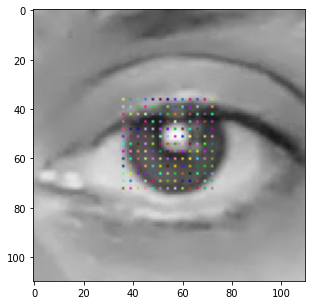

In [4]:
# plot all potential iris centers
img_dot = dve.plot_all_potential_iris_centers()

Also we presume, that iris could not be less than a circle with a certain radius, let's say 10px, and also it coud not be more than certain radius, let's say 30px.

Now for each circle between min and max radius with the step 2px, we will take all pixel values and sum them up.

We selected 2px radii step for plotting clarity.

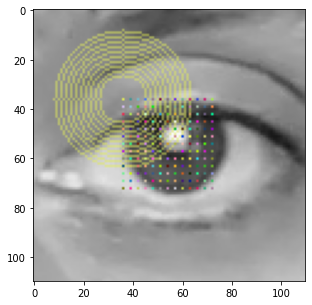

In [5]:
img_circles = dve.plot_circles_for_one_center(img_dot, dot_idx=0)

Daugman will find the best iris candidate among those circles, for that point

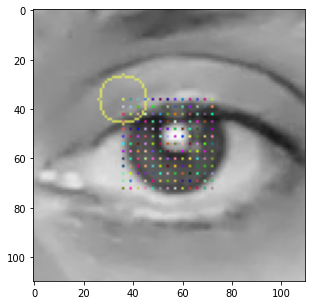

In [7]:
_ = dve.plot_best_circle_for_a_few_potential_iris_centers(img_dot, [0])

Let's do same thing for every 20th potential iris point

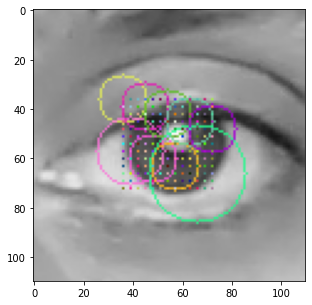

In [8]:
# plot best circle for every 20th potential iris center
_ = dve.plot_best_circle_for_a_few_potential_iris_centers(img_dot, range(0, len(dve.all_points), 20))

And now forr each potential point. It is hard to percieve, but the best iris candidate will be selected among them 

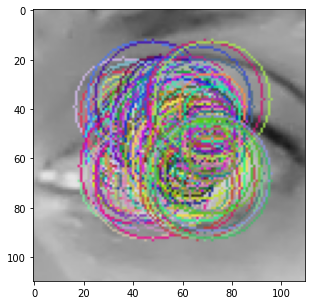

In [9]:
# plot best circle for every 20th potential iris center
_ = dve.plot_best_circle_for_a_few_potential_iris_centers(img_dot, range(0, len(dve.all_points)))

It will be the circle with the highest value (biggest delta). With selected parameters, it would be below result

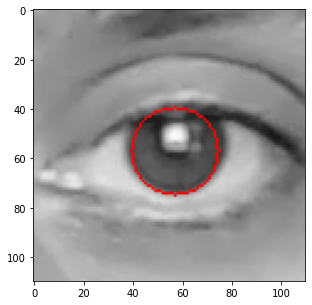

In [10]:
_ = dve.find_iris()

## Best possible result

Below you may find best possible result for given image (every dot in central third of the image, radii step 1px)

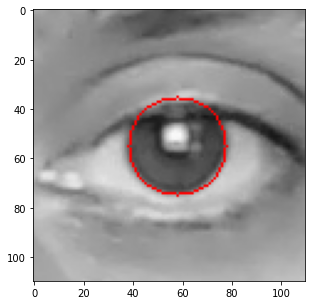

In [11]:
import cv2

img = cv2.imread('eye.jpg')
img = img[20:130, 20:130]
gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

answer = find_iris(gray_img, daugman_start=10, daugman_end=40, daugman_step=1, points_step=1)
# print(answer)

iris_center, iris_rad = answer
out = cv2.cvtColor(gray_img, cv2.COLOR_GRAY2BGR)
cv2.circle(out, iris_center, iris_rad, (0, 0, 255), 1)

_ = plt.imshow(out[::,::,::-1])